In [102]:
# Sunspot Forecasting with Recursive LightGBM and Feature Engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from pandas.tseries.offsets import MonthBegin
import warnings


In [103]:

# Suppress warnings and numpy errors
warnings.filterwarnings("ignore")
np.seterr(all='ignore')


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [104]:

# Load and preprocess data
df = pd.read_csv("Sunspots.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns = 'Unnamed: 0',inplace=True)
df.drop(index=df[df["Monthly Mean Total Sunspot Number"] == 0].index,inplace=True)

df = df[~df['Year'].between(1790, 1830)]
df = df.reset_index(drop=True)


In [105]:

# Feature engineering
df['Sunspot_lag1'] = df['Monthly Mean Total Sunspot Number'].shift(1)
df['Sunspot_lag12'] = df['Monthly Mean Total Sunspot Number'].shift(12)
df['Sunspot_lag132'] = df['Monthly Mean Total Sunspot Number'].shift(132)
df['Diff_1Year'] = df['Sunspot_lag1'] - df['Sunspot_lag12']
df['Diff_11Year'] = df['Sunspot_lag1'] - df['Sunspot_lag132']
df['RollingMean_6'] = df['Monthly Mean Total Sunspot Number'].rolling(6).mean()
df['RollingStd_6'] = df['Monthly Mean Total Sunspot Number'].rolling(6).std()
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df = df.dropna().reset_index(drop=True)


In [106]:

# Prepare features and scale
features = [
    'Month_sin', 'Month_cos', 'Year', 'Month',
    'Sunspot_lag1', 'Sunspot_lag12', 'Sunspot_lag132',
    'Diff_11Year', 'Diff_1Year', 'RollingMean_6', 'RollingStd_6'
]

X = df[features]
y = df['Monthly Mean Total Sunspot Number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [107]:

# Grid search for best LightGBM parameters
params = {
    'n_estimators': [200, 400],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 64],
    'max_depth': [-1, 10],
    'min_child_samples': [5, 20]
}

model = LGBMRegressor(random_state=42, verbose=-1)
grid = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_


In [108]:

# Recursive forecast for next 24 months
future_steps = 24
last_row = df.iloc[-1:].copy()
future_predictions = []
future_dates = []

for i in range(future_steps):
    next_date = last_row['Date'].values[0] + MonthBegin(1)
    next_month = next_date.month
    next_year = next_date.year

    row = {
        'Date': next_date,
        'Month': next_month,
        'Year': next_year,
        'Month_sin': np.sin(2 * np.pi * next_month / 12),
        'Month_cos': np.cos(2 * np.pi * next_month / 12),
        'Sunspot_lag1': last_row['Monthly Mean Total Sunspot Number'].values[0],
        'Sunspot_lag12': df.iloc[-12 + i]['Monthly Mean Total Sunspot Number'] if i < 12 else future_predictions[i - 12],
        'Sunspot_lag132': df.iloc[-132 + i]['Monthly Mean Total Sunspot Number'] if i < 132 else future_predictions[i - 132],
    }

    row['Diff_1Year'] = row['Sunspot_lag1'] - row['Sunspot_lag12']
    row['Diff_11Year'] = row['Sunspot_lag1'] - row['Sunspot_lag132']

    full_series = pd.concat([
        df['Monthly Mean Total Sunspot Number'],
        pd.Series(future_predictions)
    ], ignore_index=True)

    row['RollingMean_6'] = full_series.rolling(6).mean().iloc[-1]
    row['RollingStd_6'] = full_series.rolling(6).std().iloc[-1]

    X_future = pd.DataFrame([row])[features]
    X_future_scaled = scaler.transform(X_future)
    pred = best_model.predict(X_future_scaled)[0]

    row['Monthly Mean Total Sunspot Number'] = pred
    last_row = pd.DataFrame([row])
    future_predictions.append(pred)
    future_dates.append(next_date)


In [109]:

# Filter last 5 years and forecast for plotting
cutoff_start = df['Date'].max() - pd.DateOffset(years=5)
df_recent = df[df['Date'] >= cutoff_start]



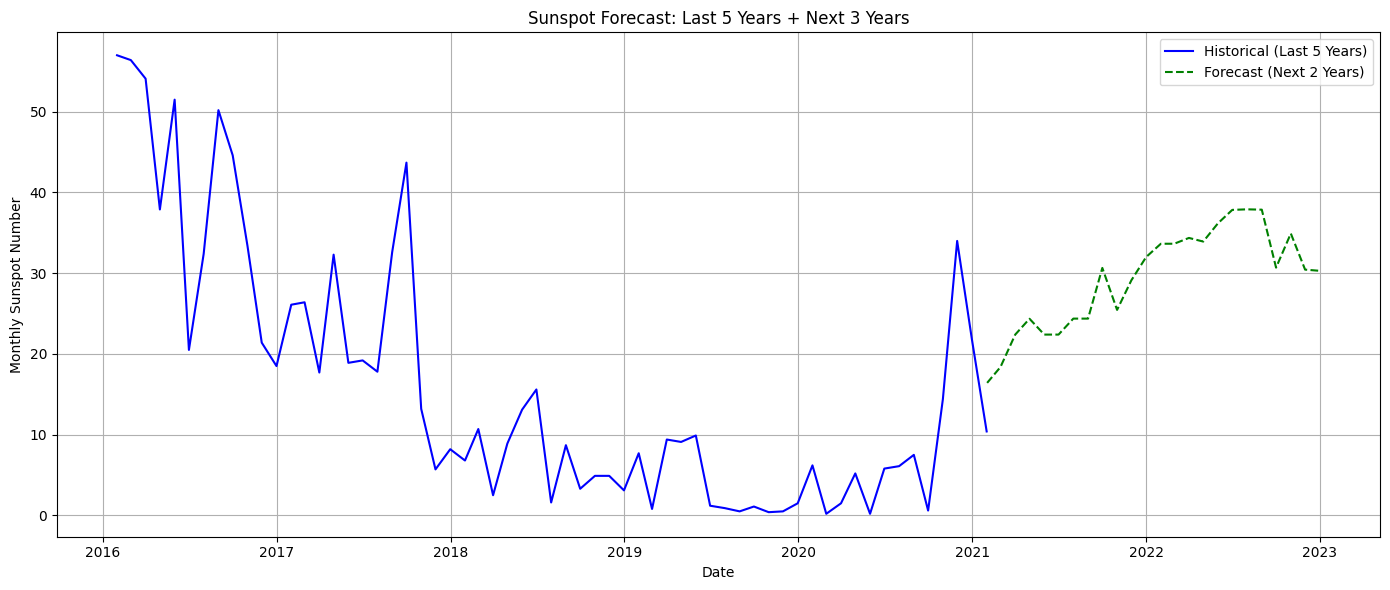

In [110]:
# Plot forecast (last 11 years + next 2 years)
plt.figure(figsize=(14,6))
plt.plot(df_recent['Date'], df_recent['Monthly Mean Total Sunspot Number'], label='Historical (Last 5 Years)', color='blue')
plt.plot(future_dates, future_predictions, label='Forecast (Next 2 Years)', color='green', linestyle='--')
plt.title("Sunspot Forecast: Last 5 Years + Next 3 Years")
plt.xlabel("Date")
plt.ylabel("Monthly Sunspot Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [111]:

# Save forecast
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Sunspot': future_predictions
})
forecast_df.to_csv("sunspot_forecast_recursive.csv", index=False)
